# Programmers Skill Check Assignments 
## 채용공고추천

* Dataset 정보

```
1. train.csv  
userID : 개발자의 ID
jobID : 구직공고의 ID
applied : 지원 여부

2. job_tags.csv
jobID : 구직공고의 ID
tagID : 직업에 해당하는 키워드

3. user_tags.csv
user_ID : 개발자의 ID
tagID: 각 개발자가 관심사로 등록한 키워드

4. tags.csv 
tagID : 키워드
keyword : 키워드가 실제로 무엇을 의미하는지

5. job_companies.csv
companyID : 회사
jobID : 회사의 구직공고
companySize : 회사의 규모

6. test_job.csv 
userID : 개발자의 ID
jobID : 구직공고의 ID
```

In [1]:
!pip install gensim

In [2]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import missingno

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec

In [3]:
train = pd.read_csv("train.csv")
job_tags = pd.read_csv("job_tags.csv")
user_tags = pd.read_csv("user_tags.csv")
tags = pd.read_csv("tags.csv")
job_companies =  pd.read_csv("job_companies.csv")
test_job = pd.read_csv("test_job.csv")

## 데이터 확인

In [4]:
train.head()

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   userID   6000 non-null   object
 1   jobID    6000 non-null   object
 2   applied  6000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 140.8+ KB


In [6]:
print(f"고유 아이디 수: {len(train.userID.unique())}")
print(f"고유 채용 공고 수: {len(train.jobID.unique())}")

고유 아이디 수: 196
고유 채용 공고 수: 708


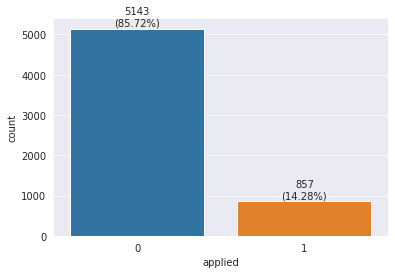

In [7]:
sns.countplot(train["applied"])
object_cnt = train["applied"].value_counts()
for x,y,z in zip(object_cnt.index, object_cnt.values, object_cnt.values/object_cnt.sum()*100):
    plt.annotate(f"{y}\n({round(z,2)}%)", xy=(x,y+70), textcoords="data", ha="center")

* 학습 데이터는 6천개가 있으며, 고유 아이디 수는 196개, 채용 공고는 708개가 있다.
* 지원하지 않는 경우가 전체 데이터의 약 85%를 차지하고 있다.
* 887개의 고유 태그가 있고, 채용공고에 선택된 태그는 3477개, 유저가 선택한 태그는 17194개가 있다.

In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tagID    887 non-null    object
 1   keyword  887 non-null    object
dtypes: object(2)
memory usage: 14.0+ KB


In [9]:
job_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   companyID    733 non-null    object
 1   jobID        733 non-null    object
 2   companySize  643 non-null    object
dtypes: object(3)
memory usage: 17.3+ KB


In [10]:
job_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   jobID   3477 non-null   object
 1   tagID   3477 non-null   object
dtypes: object(2)
memory usage: 54.5+ KB


* 유저 별 지원한(applied=1) 채용공고 리스트 추출

In [11]:
user_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17194 entries, 0 to 17193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  17194 non-null  object
 1   tagID   17194 non-null  object
dtypes: object(2)
memory usage: 268.8+ KB


* job_company의 companySize를 제외하고 결측치 없음
* 태그 중복 확인

In [12]:
print("user_tags 중복 개수:", user_tags.duplicated().sum())
print("job_tags 중복 개수:", job_tags.duplicated().sum())
print("job_companies 중복 개수:", job_companies.duplicated().sum())
print("train 중복 개수:", train.duplicated().sum())

user_tags 중복 개수: 14612
job_tags 중복 개수: 0
job_companies 중복 개수: 0
train 중복 개수: 0


user_tags에 14612개의 중복이 있으므로 중복 제거

In [13]:
# user_tags = user_tags.drop_duplicates().reset_index(drop=True)
# print("user_tags 중복 개수:", user_tags.duplicated().sum())
# user_tags

* userID와 jobID 변환 : 아이디가 너무 길어서 보기 힘드므로 짧게 변환

In [14]:
user_ids = pd.Series([x+1 for x in range(len(train["userID"].unique()))])
user_ids.index = train["userID"].unique()
user_id_dict = user_ids.to_dict()
str(user_id_dict)[:300]

"{'fe292163d06253b716e9a0099b42031d': 1, '6377fa90618fae77571e8dc90d98d409': 2, '8ec0888a5b04139be0dfe942c7eb4199': 3, 'f862b39f767d3a1991bdeb2ea1401c9c': 4, 'cac14930c65d72c16efac2c51a6b7f71': 5, 'ed1ca6971578b1da0e4ad55b48d77fda': 6, '8109c2c482264f96f8ac69a9a99db308': 7, '14ccd7a3d2daa57d06f4741f0"

In [15]:
job_ids = pd.Series([x+1 for x in range(len(job_tags["jobID"].unique()))])
job_ids.index = job_tags["jobID"].unique()
job_id_dict = job_ids.to_dict()
str(job_id_dict)[:300]

"{'320722549d1751cf3f247855f937b982': 1, 'e744f91c29ec99f0e662c9177946c627': 2, 'e820a45f1dfc7b95282d10b6087e11c0': 3, '53c3bce66e43be4f209556518c2fcb54': 4, 'fd06b8ea02fe5b1c2496fe1700e9d16c': 5, '6e7d2da6d3953058db75714ac400b584': 6, '818f4654ed39a1c147d1e51a00ffb4cb': 7, '019d385eb67632a7e958e23f2"

In [16]:
company_ids = pd.Series([x+1 for x in range(len(job_companies["companyID"].unique()))])
company_ids.index = job_companies["companyID"].unique()
company_id_dict = company_ids.to_dict()
str(company_id_dict)[:300]

"{'00411460f7c92d2124a67ea0f4cb5f85': 1, '1905aedab9bf2477edc068a355bba31a': 2, '89fcd07f20b6785b92134bd6c1d0fa42': 3, 'acf4b89d3d503d8252c9c4ba75ddbf6d': 4, 'fb7b9ffa5462084c5f4e7e85a093e6d7': 5, 'ac627ab1ccbdb62ec96e702f07f6425b': 6, '9ad6aaed513b73148b7d49f70afcfb32': 7, 'd707329bece455a462b58ce00"

In [17]:
train["userID"].replace(user_id_dict, inplace=True)
train["jobID"].replace(job_id_dict, inplace=True)
job_tags["jobID"].replace(job_id_dict, inplace=True)
user_tags["userID"].replace(user_id_dict, inplace=True)
job_companies["jobID"].replace(job_id_dict, inplace=True)
job_companies["companyID"].replace(company_id_dict, inplace=True)
test_job["userID"].replace(user_id_dict, inplace=True)
test_job["jobID"].replace(job_id_dict, inplace=True)

In [18]:
str(job_id_dict)[:300]

"{'320722549d1751cf3f247855f937b982': 1, 'e744f91c29ec99f0e662c9177946c627': 2, 'e820a45f1dfc7b95282d10b6087e11c0': 3, '53c3bce66e43be4f209556518c2fcb54': 4, 'fd06b8ea02fe5b1c2496fe1700e9d16c': 5, '6e7d2da6d3953058db75714ac400b584': 6, '818f4654ed39a1c147d1e51a00ffb4cb': 7, '019d385eb67632a7e958e23f2"

In [19]:
train.head()

,userID,jobID,applied
0,1,372,0
1,2,458,0
2,3,527,1
3,4,316,0
4,5,49,0


In [20]:
def applied_job_list(x):
    return x.loc[x["applied"]==1, "jobID"].tolist()

In [21]:
applied_list = train.groupby(["userID"])[["userID","jobID", "applied"]].apply(lambda x: applied_job_list(x))
applied_list

userID
1      [357, 378, 171, 122, 155, 126, 47, 434]
2                                           []
3                              [527, 730, 134]
4                     [138, 183, 10, 134, 654]
5                           [45, 320, 52, 303]
                        ...                   
192                       [171, 378, 126, 122]
193                            [713, 378, 518]
194                             [122, 717, 19]
195                                      [134]
196                     [514, 125, 19, 371, 2]
Length: 196, dtype: object

* 유저들이 가장 많이 지원한 10개의 공고 확인

In [22]:
train.groupby("jobID")[["applied"]].sum().reset_index().describe()

,jobID,applied
count,708.000000,708.000000
mean,360.795198,1.210452
std,210.152121,2.166233
min,1.000000,0.000000
25%,178.750000,0.000000
50%,360.500000,0.000000
75%,538.250000,1.000000
max,733.000000,18.000000


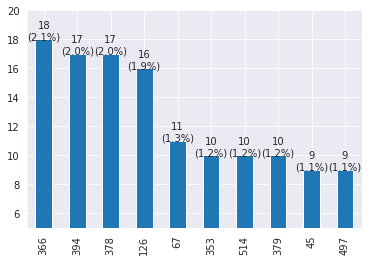

In [23]:
applied_sum = train[train["applied"]==1].count()[0] # 지원한 전체 공고 수

train.loc[train["applied"]==1, "jobID"].value_counts()[:10].plot(kind="bar", ylim=[5,20])

object_cnt = train.loc[train["applied"]==1, "jobID"].value_counts()[:10]
for x,y,z in zip(range(10), object_cnt.values, object_cnt.values/applied_sum*100):
    plt.annotate(f"{y}\n({round(z,1)}%)", xy=(x,y), textcoords="data", ha="center")

가장 많이 지원한 곳은 366번 공고이며 18명의 지원자가 있음




In [24]:
train.loc[train["applied"]==1, "jobID"].value_counts()[:10].keys()

Int64Index([366, 394, 378, 126, 67, 353, 514, 379, 45, 497], dtype='int64')

In [25]:
job_companies[job_companies["jobID"].isin([366, 394, 378, 126, 67, 353, 514, 379, 45, 497])]

,companyID,jobID,companySize
27,27,353,NaN
40,39,379,11-50
126,93,366,101-200
132,96,378,101-200
140,102,394,201-500
206,53,45,1-10
310,93,67,101-200
341,175,126,NaN
377,131,497,51-100
478,93,514,101-200


* 태그 변환

In [26]:
tags.index = tags["tagID"]
tags_to_dict = tags["keyword"].to_dict()
str(tags_to_dict)[:300]

"{'602d1305678a8d5fdb372271e980da6a': 'Amazon Web Services(AWS)', 'e3251075554389fe91d17a794861d47b': 'Tensorflow', 'a1d50185e7426cbb0acad1e6ca74b9aa': 'Docker', '884d79963bd8bc0ae9b13a1aa71add73': 'Git', '4122cb13c7a474c1976c9706ae36521d': 'Python', '6e7d2da6d3953058db75714ac400b584': 'Go', '208e43f"

In [27]:
user_tags["tagID"].replace(tags_to_dict, inplace=True)
user_tags

,userID,tagID
0,72,JUnit
1,72,Spring
2,72,WebSocket
3,72,Spring Boot
4,72,JavaScript
...,...,...
17189,164,CSS
17190,164,HTML5
17191,164,Java
17192,52,ExpressJS


In [28]:
temp = user_tags.groupby(["tagID"])["tagID"].count()
user_tags_grouped_df = pd.DataFrame({"tag":temp.index, "count":temp})
user_tags_grouped_df.reset_index(drop=True, inplace=True)

In [29]:
other_row = pd.DataFrame({"tag":['others'],
              "count": [user_tags_grouped_df.sort_values(by="count")["count"].iloc[:-10].sum()]})
user_tags_grouped_df = pd.concat([user_tags_grouped_df, other_row], axis=0, ignore_index=True)
user_tags_grouped_df.sort_values(by="count", ascending=False).iloc[:11]

,tag,count
345,others,11909
159,Java,820
163,JavaScript,796
204,MySQL,701
279,Spring,564
217,Node.js,516
34,Android,398
334,jQuery,385
142,HTML,381
251,ReactJS,380


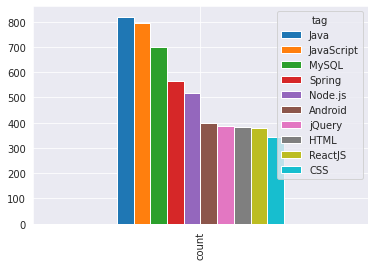

In [30]:
user_tags_grouped_df.sort_values(by="count", ascending=False).iloc[1:11].set_index('tag').T.plot(kind='bar')

* 가장 많이 선택된 상위 10개의 태그 + others
* 풀스택 관련 언어가 상위 10위를 차지하고 있다.


In [31]:
job_tags["tagID"].replace(tags_to_dict, inplace=True)
job_tags

,jobID,tagID
0,1,Ruby
1,2,Node.js
2,2,JavaScript
3,3,HTML
4,3,Vue.js
...,...,...
3472,710,C++
3473,711,Swift
3474,711,Realm
3475,711,Firebase


In [32]:
temp = job_tags.groupby(["tagID"])["tagID"].count()
job_tags_grouped_df = pd.DataFrame({"tag":temp.index, "count":temp})
job_tags_grouped_df.reset_index(drop=True, inplace=True)

other_row = pd.DataFrame({"tag":['others'],
              "count": [job_tags_grouped_df.sort_values(by="count")["count"].iloc[:-15].sum()]})
job_tags_grouped_df = pd.concat([job_tags_grouped_df, other_row], axis=0, ignore_index=True)
job_tags_grouped_df.sort_values(by="count", ascending=False).iloc[:16]

,tag,count
240,others,1727
114,JavaScript,219
113,Java,197
170,Python,187
150,Node.js,153
141,MySQL,143
177,ReactJS,131
102,HTML,115
52,CSS,114
88,Git,103


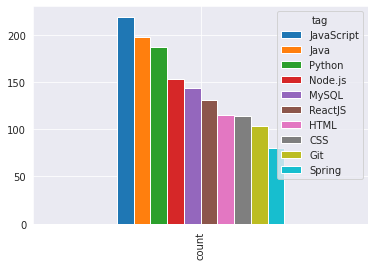

In [33]:
job_tags_grouped_df.sort_values(by="count", ascending=False).iloc[1:11].set_index('tag').T.plot(kind='bar')

* 구직공고에서 원하는 기술도 대부분 풀스택 기술인 것으로 보인다.

In [34]:
job_tags_count_df = job_tags.groupby(["tagID"])[["tagID"]].count()
job_tags_count_df = job_tags_count_df.rename(columns={"tagID": "tag_counts"})
job_tags_count_df = job_tags_count_df.reset_index()
job_tags_count_df

,tagID,tag_counts
0,.NET,9
1,ASP,2
2,ASP.NET,4
3,AWS Backup,1
4,AWS CloudWatch,1
...,...,...
235,iOS,38
236,jQuery,45
237,mSQL,1
238,styled-components,2


In [35]:
user_tags

,userID,tagID
0,72,JUnit
1,72,Spring
2,72,WebSocket
3,72,Spring Boot
4,72,JavaScript
...,...,...
17189,164,CSS
17190,164,HTML5
17191,164,Java
17192,52,ExpressJS


결측치의 개수:  90


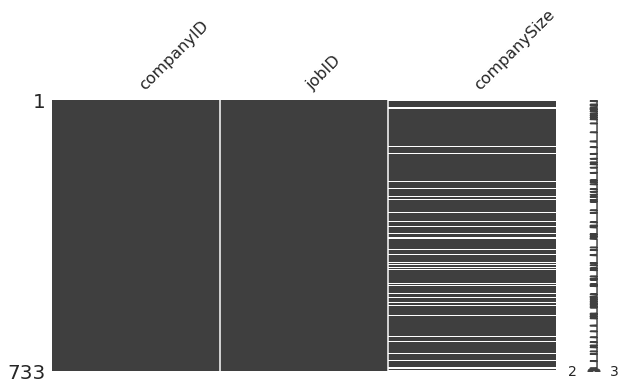

In [36]:
missingno.matrix(job_companies, figsize=(10,5))
print("결측치의 개수: ",job_companies["companySize"].isna().sum())

* 90개의 회사의 companySize 정보가 비어있음
* 채용 공고의 개수로 회사 규모를 알 수 있을까?

* 회사 규모가 결측치인 곳은 1~9 개의 채용 공고를 냈으며 규모가 200이하인 기업들도 대체로 1 ~ 10개의 채용 공고가 있다.
* 회사 규모가 나오지 않는다는 것은 신생 기업이거나 소규모 기업일 가능성이 높음
* 따라서 1-10 으로 결측치를 대체하기로 함

* applied_list : 유저가 지원한 회사 리스트
* user_tag_list : 유저의 태그 리스트
* job_info : 채용공고를 낸 회사정보와 태그 리스트

In [37]:
job_tags_list = job_tags.groupby("jobID")[["tagID"]].apply(lambda x: x["tagID"].tolist()).rename("jobTag")
job_tags_list

jobID
1                                  [Ruby, Ruby on Rails]
2                             [Node.js, JavaScript, Git]
3      [HTML, Vue.js, AngularJS, JavaScript, CSS, Rea...
4                          [Apache Spark, Apache Hadoop]
5      [Django, Docker, AWS EC2, JavaScript, BitBucke...
                             ...                        
729                                            [Android]
730                                       [React Native]
731                                              [Swift]
732                                       [React Native]
733                                              [Swift]
Name: jobTag, Length: 733, dtype: object

In [38]:
job_info = pd.merge(job_tags_list,job_companies, on="jobID").set_index('jobID')
job_info

,jobTag,companyID,companySize
jobID,,,
1,"[Ruby, Ruby on Rails]",35,11-50
2,"[Node.js, JavaScript, Git]",61,51-100
3,"[HTML, Vue.js, AngularJS, JavaScript, CSS, Rea...",154,1-10
4,"[Apache Spark, Apache Hadoop]",40,201-500
5,"[Django, Docker, AWS EC2, JavaScript, BitBucke...",155,1-10
...,...,...,...
729,[Android],26,101-200
730,[React Native],189,1-10
731,[Swift],67,101-200


In [39]:
job_info = job_info.fillna("1-10")
job_info

,jobTag,companyID,companySize
jobID,,,
1,"[Ruby, Ruby on Rails]",35,11-50
2,"[Node.js, JavaScript, Git]",61,51-100
3,"[HTML, Vue.js, AngularJS, JavaScript, CSS, Rea...",154,1-10
4,"[Apache Spark, Apache Hadoop]",40,201-500
5,"[Django, Docker, AWS EC2, JavaScript, BitBucke...",155,1-10
...,...,...,...
729,[Android],26,101-200
730,[React Native],189,1-10
731,[Swift],67,101-200


In [40]:
company_size_dict = {x:i for i, x in enumerate(sorted(job_info.companySize.unique(), key=lambda x: int((x.split("-"))[0].split()[0])))}
company_size_dict

{'1-10': 0,
 '1000 이상': 6,
 '101-200': 3,
 '11-50': 1,
 '201-500': 4,
 '501-1000': 5,
 '51-100': 2}

In [41]:
train = pd.merge(train, job_info, on="jobID")
train

,userID,jobID,applied,jobTag,companyID,companySize
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50
1,33,372,0,"[Ruby on Rails, Ruby]",35,11-50
2,22,372,0,"[Ruby on Rails, Ruby]",35,11-50
3,158,372,1,"[Ruby on Rails, Ruby]",35,11-50
4,91,372,0,"[Ruby on Rails, Ruby]",35,11-50
...,...,...,...,...,...,...
5995,115,599,0,"[Python, Apache Hadoop, SQL, Java, JavaScript,...",134,501-1000
5996,112,202,0,"[Swift, iOS, Objective-C]",165,11-50
5997,47,442,0,"[AWS EC2, Docker, AWS RDS]",35,11-50
5998,53,558,1,"[Swift, Tensorflow, Python, JSP, Ionic, Vue.js...",223,1-10


중복있는 유저 태그
- 태그의 중복이 왜 발생했는지가 중요할 것 같다.
- 단순히 유저가 채용공고를 열람할 때마다 태그가 추가된 것 같지는 않다. 
- 만약 열람할 때마다 태그가 중복됐다면 중복된 태그의 갯수가 모두 동일해야 하는데 그렇지 않다.
- 따라서 중복된 태그의 갯수를 유저가 단순히 중복해서 채크 했다고 가정하고 중복된 갯수만큼 태그의 선호도로 나타낸다.

In [42]:
train

,userID,jobID,applied,jobTag,companyID,companySize
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50
1,33,372,0,"[Ruby on Rails, Ruby]",35,11-50
2,22,372,0,"[Ruby on Rails, Ruby]",35,11-50
3,158,372,1,"[Ruby on Rails, Ruby]",35,11-50
4,91,372,0,"[Ruby on Rails, Ruby]",35,11-50
...,...,...,...,...,...,...
5995,115,599,0,"[Python, Apache Hadoop, SQL, Java, JavaScript,...",134,501-1000
5996,112,202,0,"[Swift, iOS, Objective-C]",165,11-50
5997,47,442,0,"[AWS EC2, Docker, AWS RDS]",35,11-50
5998,53,558,1,"[Swift, Tensorflow, Python, JSP, Ionic, Vue.js...",223,1-10


In [43]:
from collections import Counter
train = pd.merge(train, user_tags.groupby("userID")[["tagID"]].apply(lambda x: Counter(x["tagID"])).rename("user_tags_count").reset_index(), left_on="userID", right_on="userID")

In [44]:
user_tags.groupby("userID")[["tagID"]].apply(lambda x: Counter(x["tagID"])).reset_index()

,userID,0
0,1,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen..."
1,2,"{'Java': 5, 'Apache Tomcat': 5, 'HTML5': 5, 'R..."
2,3,"{'Raspberry Pi': 4, 'Android': 4, 'Cuckoo Sand..."
3,4,"{'MariaDB': 5, 'Raspberry Pi': 5, 'HTML': 5, '..."
4,5,"{'Spring': 5, 'AWS EC2': 5, 'CSS3': 5, 'KakaoP..."
...,...,...
191,192,"{'Thymeleaf': 4, 'Spring': 4, 'C#': 4, 'MyBati..."
192,193,"{'Gradle': 5, 'jQuery': 11, 'Spring Boot': 5, ..."
193,194,"{'RxJS': 5, 'ES6': 5, 'i18n': 5, 'RxJava': 5, ..."
194,195,"{'Android': 5, 'Raspberry Pi': 5, 'MySQL': 5, ..."


In [45]:
def cal_tag_score(df):
    tag_scores= []
    for i in df.index:
        tag_score = [0]*len(df["jobTag"][i])
        for j, tag in enumerate(df["jobTag"][i]):
            try:
                tag_score[j] = df["user_tags_count"][i][tag]
            except:
                tag_score[j]=0
        tag_scores.append(tag_score)
    return tag_scores

In [46]:
train["tag_scores"] = cal_tag_score(train)
train["tag_scores_sum"] = train.tag_scores.apply(lambda x: sum(x))
train

,userID,jobID,applied,jobTag,companyID,companySize,user_tags_count,tag_scores,tag_scores_sum
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...","[0, 0]",0
1,1,730,0,[React Native],189,1-10,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...",[0],0
2,1,413,0,"[Java, Kotlin]",45,11-50,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...","[12, 0]",12
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...","[0, 0, 12, 0, 0]",12
4,1,59,0,"[C++, C#]",40,201-500,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...","[0, 0]",0
...,...,...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,"{'Bootstrap': 5, 'Java': 5, 'Spring': 5, 'Djan...","[5, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5]",30
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,"{'Bootstrap': 5, 'Java': 5, 'Spring': 5, 'Djan...","[0, 5, 0]",5
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,"{'Bootstrap': 5, 'Java': 5, 'Spring': 5, 'Djan...","[0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 5]",15
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,"{'Android': 5, 'Raspberry Pi': 5, 'MySQL': 5, ...","[0, 5, 0, 0, 0, 5, 0, 0, 0, 0]",10


In [47]:
train[train["applied"]==1].describe()

,userID,jobID,applied,companyID,tag_scores_sum
count,857.000000,857.000000,857.0,857.000000,857.000000
mean,91.029172,297.252042,1.0,85.410735,14.317386
std,56.372864,201.357611,0.0,61.830313,14.188306
min,1.000000,2.000000,1.0,1.000000,0.000000
25%,40.000000,110.000000,1.0,35.000000,5.000000
50%,90.000000,325.000000,1.0,72.000000,10.000000
75%,141.000000,434.000000,1.0,127.000000,20.000000
max,196.000000,733.000000,1.0,276.000000,119.000000


In [48]:
train[train["applied"]==0].describe()

,userID,jobID,applied,companyID,tag_scores_sum
count,5143.000000,5143.000000,5143.0,5143.000000,5143.000000
mean,88.475015,289.507486,0.0,81.908419,9.537624
std,52.680946,194.973470,0.0,62.068979,12.320753
min,1.000000,1.000000,0.0,1.000000,0.000000
25%,45.000000,100.000000,0.0,32.000000,0.000000
50%,86.000000,313.000000,0.0,67.000000,5.000000
75%,130.000000,430.000000,0.0,123.000000,13.000000
max,196.000000,732.000000,0.0,275.000000,130.000000


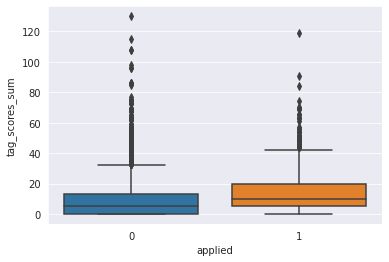

In [49]:
sns.boxplot(data = train[["applied", "tag_scores_sum"]], x="applied", y = "tag_scores_sum")

카이제곱검정 : 두 변수가 독립인지 종속인지 확인

In [50]:
from scipy.stats import *
kstest(train[["applied"]].values, 'norm')

KstestResult(statistic=0.8413447460685429, pvalue=0.0)

In [51]:
kstest(train[["tag_scores_sum"]].values, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

두 변수가 정규분포를 따름

In [52]:
cross_table = pd.crosstab(train["applied"], train["tag_scores_sum"])
obs = cross_table.values
statistics, pvalue, dof, expected = chi2_contingency(obs)

In [53]:
pvalue < 0.05

True

p-value가 0.05 미만이므로 두 변수가 서로 종속적이라고 할 수 있다.




In [54]:
train.columns

Index(['userID', 'jobID', 'applied', 'jobTag', 'companyID', 'companySize',
       'user_tags_count', 'tag_scores', 'tag_scores_sum'],
      dtype='object')

In [55]:
train[['applied', 'tag_scores_sum']].corr()

,applied,tag_scores_sum
applied,1.000000,0.131559
tag_scores_sum,0.131559,1.000000


태그 점수가 높아도 지원하지 않은 이유는 무엇일까
- 유저가 지원한 공고의 태그점수의 평균은 14이다. 태그 점수가 14점 이상인데, 지원하지 않았을 경우를 살펴보았다.
- 개인적인 경험으로는 경력제한에 걸렸다거나 나중에 지원하려고 보류 등과 같은 이유가 있을 것 같다.

In [56]:
train[(train["applied"]==0) & (train["tag_scores_sum"]>=14)]

,userID,jobID,applied,jobTag,companyID,companySize,user_tags_count,tag_scores,tag_scores_sum
8,1,381,0,"[Scala, Python, C#, Java, Datadog, Rust, Go, C...",40,201-500,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...","[0, 12, 0, 12, 0, 0, 0, 0, 0, 12]",36
9,1,467,0,"[AWS DynamoDB, Kubernetes, Jenkins, Node.js]",61,51-100,"{'MongoDB': 12, 'Docker': 12, 'Java': 12, 'Jen...","[0, 0, 12, 12]",24
31,33,131,0,"[Redis, Docker, JavaScript, CSS, ES6, MySQL, N...",126,11-50,"{'Handlebars.js': 6, 'Apache Maven': 5, 'Keras...","[0, 0, 6, 6, 5, 6, 0, 0, 6, 0, 0]",29
36,33,27,0,"[MySQL, Java, MongoDB, Node.js, OOP, Linux, Py...",30,1000 이상,"{'Handlebars.js': 6, 'Apache Maven': 5, 'Keras...","[6, 6, 0, 0, 0, 0, 6, 0, 0, 0, 6]",24
38,33,228,0,"[HTML, JavaScript, CSS, jQuery, ASP.NET]",257,11-50,"{'Handlebars.js': 6, 'Apache Maven': 5, 'Keras...","[6, 6, 6, 0, 0]",18
...,...,...,...,...,...,...,...,...,...
5984,194,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,"{'RxJS': 5, 'ES6': 5, 'i18n': 5, 'RxJava': 5, ...","[0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 5]",30
5985,194,262,0,"[AngularJS, HTML, jQuery, JavaScript]",50,201-500,"{'RxJS': 5, 'ES6': 5, 'i18n': 5, 'RxJava': 5, ...","[0, 5, 5, 5]",15
5986,194,169,0,"[Node.js, HTML, ReactJS, CSS, JavaScript, Reac...",151,1-10,"{'RxJS': 5, 'ES6': 5, 'i18n': 5, 'RxJava': 5, ...","[5, 5, 5, 5, 5, 0]",25
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,"{'Bootstrap': 5, 'Java': 5, 'Spring': 5, 'Djan...","[5, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5]",30


### 가설1: 유저와 채용공고 간 겹치는 태그가 많을 수록 지원을 많이 할 것이다.
- jobTag와 userTag의 교집합을 합집합으로 나눈 값을 tag_ratio로 만들고 applied와 상관관계 확인

유저 태그와 채용공고의 태그가 겹치는 비율을 tag_ratio로 만듦

In [57]:
train.drop(["tag_scores","user_tags_count"], axis=1, inplace=True)
train

,userID,jobID,applied,jobTag,companyID,companySize,tag_scores_sum
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,0
1,1,730,0,[React Native],189,1-10,0
2,1,413,0,"[Java, Kotlin]",45,11-50,12
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,12
4,1,59,0,"[C++, C#]",40,201-500,0
...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,30
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,5
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,15
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,10


In [58]:
user_tags_list = user_tags.groupby("userID")[["tagID"]].apply(lambda x: x["tagID"].to_list()).rename("userTag").reset_index()
user_tags_list

,userID,userTag
0,1,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op..."
1,2,"[Java, Apache Tomcat, HTML5, ReactJS, Apache S..."
2,3,"[Raspberry Pi, Android, Cuckoo Sandbox, Facebo..."
3,4,"[MariaDB, Raspberry Pi, HTML, TypeScript, Flas..."
4,5,"[Spring, AWS EC2, CSS3, KakaoPay API, Spring D..."
...,...,...
191,192,"[Thymeleaf, Spring, Thymeleaf, Spring, C#, MyB..."
192,193,"[Gradle, jQuery, Spring Boot, HTML, MySQL, Jav..."
193,194,"[RxJS, ES6, i18n, RxJava, Apache Maven, Spring..."
194,195,"[Android, Raspberry Pi, MySQL, Linux, C, Maria..."


In [59]:
train = pd.merge(train, user_tags_list, on="userID")
train

,userID,jobID,applied,jobTag,companyID,companySize,tag_scores_sum,userTag
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op..."
1,1,730,0,[React Native],189,1-10,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op..."
2,1,413,0,"[Java, Kotlin]",45,11-50,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op..."
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op..."
4,1,59,0,"[C++, C#]",40,201-500,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op..."
...,...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,30,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr..."
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,5,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr..."
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,15,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr..."
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,10,"[Android, Raspberry Pi, MySQL, Linux, C, Maria..."


In [60]:
train["tags_union"] = train["jobTag"] + train["userTag"].apply(lambda x: list(set(x)))
train["tags_union"].apply(lambda x: x)
train

,userID,jobID,applied,jobTag,companyID,companySize,tag_scores_sum,userTag,tags_union
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Ruby on Rails, Ruby, ExpressJS, Machine Learn..."
1,1,730,0,[React Native],189,1-10,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[React Native, ExpressJS, Machine Learning, No..."
2,1,413,0,"[Java, Kotlin]",45,11-50,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Java, Kotlin, ExpressJS, Machine Learning, No..."
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[NoSQL, Amazon Web Services(AWS), Java, REST A..."
4,1,59,0,"[C++, C#]",40,201-500,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[C++, C#, ExpressJS, Machine Learning, Node.js..."
...,...,...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,30,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Django, MongoDB, Vue.js, ReactJS, HTML, Java,..."
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,5,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[PostgreSQL, Python, AWS Lambda, Spring, Djang..."
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,15,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Redis, jQuery, Elasticsearch, Apache Tomcat, ..."
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,10,"[Android, Raspberry Pi, MySQL, Linux, C, Maria...","[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver..."


In [61]:
train["tag_ratio"] = 1 - (train["userTag"].apply(lambda x: list(set(x))) + train["jobTag"].apply(lambda x: x)).apply(lambda x: len(set(x))) /train["tags_union"].apply(lambda x: len(x))
train

,userID,jobID,applied,jobTag,companyID,companySize,tag_scores_sum,userTag,tags_union,tag_ratio
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Ruby on Rails, Ruby, ExpressJS, Machine Learn...",0.000000
1,1,730,0,[React Native],189,1-10,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[React Native, ExpressJS, Machine Learning, No...",0.000000
2,1,413,0,"[Java, Kotlin]",45,11-50,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Java, Kotlin, ExpressJS, Machine Learning, No...",0.066667
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[NoSQL, Amazon Web Services(AWS), Java, REST A...",0.055556
4,1,59,0,"[C++, C#]",40,201-500,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[C++, C#, ExpressJS, Machine Learning, Node.js...",0.000000
...,...,...,...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,30,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",0.272727
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,5,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[PostgreSQL, Python, AWS Lambda, Spring, Djang...",0.071429
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,15,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",0.125000
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,10,"[Android, Raspberry Pi, MySQL, Linux, C, Maria...","[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",0.111111


In [62]:
train.describe()

,userID,jobID,applied,companyID,tag_scores_sum,tag_ratio
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,88.839833,290.613667,0.142833,82.408667,10.220333,0.075442
std,53.226573,195.899724,0.349932,62.041909,12.713670,0.066518
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,44.000000,102.750000,0.000000,32.000000,0.000000,0.000000
50%,87.000000,314.000000,0.000000,67.000000,6.000000,0.066667
75%,133.000000,431.000000,0.000000,124.250000,14.000000,0.113799
max,196.000000,733.000000,1.000000,276.000000,130.000000,0.500000


지원자의 적극도 반영
- 성향에 따라 신중하게 지원하는 지원자가 있는 반면, 적극적으로 지원하는  지원자도 있음. 
- 테스트할 데이터의 고유 userid가 같기 때문에 이를 현재까지 지원한 공고의 갯수로 나타냄


In [63]:
sorted(train.userID.unique()) == sorted(test_job.userID.unique()) 

True

In [64]:
train = pd.merge(train, train.groupby("userID")[["applied"]].sum().reset_index(), left_on="userID", right_on="userID")
train

,userID,jobID,applied_x,jobTag,companyID,companySize,tag_scores_sum,userTag,tags_union,tag_ratio,applied_y
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Ruby on Rails, Ruby, ExpressJS, Machine Learn...",0.000000,8
1,1,730,0,[React Native],189,1-10,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[React Native, ExpressJS, Machine Learning, No...",0.000000,8
2,1,413,0,"[Java, Kotlin]",45,11-50,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Java, Kotlin, ExpressJS, Machine Learning, No...",0.066667,8
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[NoSQL, Amazon Web Services(AWS), Java, REST A...",0.055556,8
4,1,59,0,"[C++, C#]",40,201-500,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[C++, C#, ExpressJS, Machine Learning, Node.js...",0.000000,8
...,...,...,...,...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,30,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",0.272727,3
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,5,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[PostgreSQL, Python, AWS Lambda, Spring, Djang...",0.071429,3
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,15,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",0.125000,3
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,10,"[Android, Raspberry Pi, MySQL, Linux, C, Maria...","[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",0.111111,1


In [65]:
train.rename(columns={"applied_x":"applied", "applied_y":"applied_sum"}, inplace=True)
train

,userID,jobID,applied,jobTag,companyID,companySize,tag_scores_sum,userTag,tags_union,tag_ratio,applied_sum
0,1,372,0,"[Ruby on Rails, Ruby]",35,11-50,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Ruby on Rails, Ruby, ExpressJS, Machine Learn...",0.000000,8
1,1,730,0,[React Native],189,1-10,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[React Native, ExpressJS, Machine Learning, No...",0.000000,8
2,1,413,0,"[Java, Kotlin]",45,11-50,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[Java, Kotlin, ExpressJS, Machine Learning, No...",0.066667,8
3,1,464,0,"[NoSQL, Amazon Web Services(AWS), Java, REST A...",70,1-10,12,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[NoSQL, Amazon Web Services(AWS), Java, REST A...",0.055556,8
4,1,59,0,"[C++, C#]",40,201-500,0,"[MongoDB, Docker, Java, Jenkins, ExpressJS, Op...","[C++, C#, ExpressJS, Machine Learning, Node.js...",0.000000,8
...,...,...,...,...,...,...,...,...,...,...,...
5995,191,439,0,"[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",117,11-50,30,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Django, MongoDB, Vue.js, ReactJS, HTML, Java,...",0.272727,3
5996,191,490,0,"[PostgreSQL, Python, AWS Lambda]",153,1-10,5,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[PostgreSQL, Python, AWS Lambda, Spring, Djang...",0.071429,3
5997,191,359,0,"[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",30,1000 이상,15,"[Bootstrap, Java, Spring, Bootstrap, Java, Spr...","[Redis, jQuery, Elasticsearch, Apache Tomcat, ...",0.125000,3
5998,195,134,1,"[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",13,11-50,10,"[Android, Raspberry Pi, MySQL, Linux, C, Maria...","[PostgreSQL, MariaDB, SQLAlchemy, Nginx, Naver...",0.111111,1


In [66]:
train["companySize"] = train["companySize"].replace(company_size_dict)

## 테스트 데이터 전처리

In [67]:
# test_job = pd.read_csv("test_job.csv")
# test_job["userID"].replace(user_id_dict, inplace=True)
# test_job["jobID"].replace(job_id_dict, inplace=True
test_job = pd.merge(test_job, job_info, on="jobID")
test_job = pd.merge(test_job, user_tags.groupby("userID")[["tagID"]].apply(lambda x: Counter(x["tagID"])).rename("user_tags_count").reset_index(), left_on="userID", right_on="userID")
test_job["tag_scores"] = cal_tag_score(test_job)
test_job["tag_scores_sum"] = test_job["tag_scores"].apply(lambda x: sum(x))
test_job["companySize"] = test_job["companySize"].replace(company_size_dict)
test_job.drop(["tag_scores","user_tags_count"], axis=1, inplace=True)
test_job = pd.merge(test_job, user_tags_list, on="userID")
test_job["tags_union"] = test_job["jobTag"] + test_job["userTag"].apply(lambda x: list(set(x)))
test_job["tag_ratio"] = 1 - (test_job["userTag"].apply(lambda x: list(set(x))) + test_job["jobTag"].apply(lambda x: x)).apply(lambda x: len(set(x))) /test_job["tags_union"].apply(lambda x: len(x))
# 유저의 적극도는 train set의 정보로 입력
test_job = pd.merge(test_job, train.groupby("userID")[["applied"]].sum().reset_index(), left_on="userID", right_on="userID")
test_job.rename(columns={"applied":"applied_sum"},inplace=True)
test_job

,userID,jobID,jobTag,companyID,companySize,tag_scores_sum,userTag,tags_union,tag_ratio,applied_sum
0,49,422,"[MongoDB, Git, Node.js, AWS S3, C#, HTML, Type...",110,1,33,"[CSS, PHP, AWS Cognito, CSS, PHP, AWS Cognito,...","[MongoDB, Git, Node.js, AWS S3, C#, HTML, Type...",0.150000,5
1,49,150,"[Git, ExpressJS, JavaScript, MySQL, Node.js]",78,1,22,"[CSS, PHP, AWS Cognito, CSS, PHP, AWS Cognito,...","[Git, ExpressJS, JavaScript, MySQL, Node.js, M...",0.111111,5
2,49,33,"[Mocha, CSS, Linux, REST API, Node.js, Express...",87,1,55,"[CSS, PHP, AWS Cognito, CSS, PHP, AWS Cognito,...","[Mocha, CSS, Linux, REST API, Node.js, Express...",0.217391,5
3,49,303,"[PHP, Python, MySQL]",67,3,33,"[CSS, PHP, AWS Cognito, CSS, PHP, AWS Cognito,...","[PHP, Python, MySQL, MySQL, Node.js, HTML, AWS...",0.187500,5
4,49,55,"[Java, JavaScript]",111,1,0,"[CSS, PHP, AWS Cognito, CSS, PHP, AWS Cognito,...","[Java, JavaScript, MySQL, Node.js, HTML, AWS C...",0.000000,5
...,...,...,...,...,...,...,...,...,...,...
2430,48,710,"[Qt, C++]",201,1,11,"[Trello, Embedded System, Tensorflow, Raspberr...","[Qt, C++, C, YOLO, JavaScript, Raspberry Pi, T...",0.041667,2
2431,74,61,"[ReactJS, AngularJS, JavaScript, HTML, TypeScr...",88,1,0,"[Shell, Android, C, Shell, MySQL, C, MySQL, C#...","[ReactJS, AngularJS, JavaScript, HTML, TypeScr...",0.000000,6
2432,74,203,"[Unity, JavaScript]",78,1,0,"[Shell, Android, C, Shell, MySQL, C, MySQL, C#...","[Unity, JavaScript, C, MySQL, Android, Shell, ...",0.000000,6
2433,74,213,"[Git, iOS, RxSwift, Swift]",107,0,0,"[Shell, Android, C, Shell, MySQL, C, MySQL, C#...","[Git, iOS, RxSwift, Swift, C, MySQL, Android, ...",0.000000,6


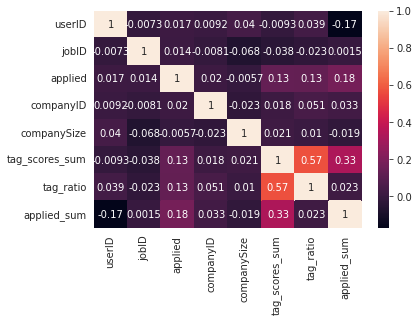

In [77]:
sns.heatmap(train.corr(), annot=True, cbar=True)

In [68]:
X = train[['tag_scores_sum', 'tag_ratio', 'applied_sum','applied']]
test = test_job[['tag_scores_sum', 'tag_ratio', 'applied_sum']]

In [69]:
y_train = X.pop("applied")
X_train = X

- feature 수가 얼마 없기 때문에 간단한 RF모델을 선정하였다.
- 또한 데이터 양이 적기 때문에 KFold를 사용하여 과대적합을 막아 일반화 성능을 높인다

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
kfold = StratifiedKFold(n_splits=5).split(X_train, y_train)

In [71]:
scores = []
forest = RandomForestClassifier(n_estimators=500, random_state=42)
for k, (tri, val) in enumerate(kfold):
    forest.fit(X_train.iloc[tri], y_train.iloc[tri])

    score = forest.score(X_train.iloc[val], y_train.iloc[val])
    scores.append(score)
    print(f'fold {k+1} 모델의 정확도: {score*100:.2f}%')

fold 1 모델의 정확도: 84.33%
fold 2 모델의 정확도: 69.75%
fold 3 모델의 정확도: 76.08%
fold 4 모델의 정확도: 74.25%
fold 5 모델의 정확도: 78.83%


In [72]:
print(f"CV 정확도: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV 정확도: 0.767 +/- 0.048


In [73]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5).split(X_train, y_train)

In [74]:
scores = []
forest = RandomForestClassifier(n_estimators=500, random_state=2022)
for k, (tri, val) in enumerate(kfold):
    forest.fit(X_train.iloc[tri], y_train.iloc[tri])

    score = forest.score(X_train.iloc[val], y_train.iloc[val])
    scores.append(score)
    print(f'fold {k+1} 모델의 정확도: {score*100:.2f}%')

fold 1 모델의 정확도: 88.08%
fold 2 모델의 정확도: 83.08%
fold 3 모델의 정확도: 82.58%
fold 4 모델의 정확도: 79.50%
fold 5 모델의 정확도: 76.92%


In [75]:
print(f"CV 정확도: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

CV 정확도: 0.820 +/- 0.038


지원여부의 비율이 일정하지 않은게 정상적인 데이터라고 생각하기 때문에 StratifiedKFold보다는 그냥  KFold의 결과가 더 신뢰성 있는 결과라고 할 수 있을 것 같다. 상관관계가 높았던 'tag_scores_sum'와 'tag_ratio' 중 하나를 뺀 결과를 확인해 보았다.

In [83]:
X = train[['tag_ratio', 'applied_sum','applied']]
test = test_job[['tag_ratio', 'applied_sum']]
y_train = X.pop("applied")
X_train = X

kfold = KFold(n_splits=5).split(X_train, y_train)
scores = []
forest = RandomForestClassifier(n_estimators=500, random_state=2022)
for k, (tri, val) in enumerate(kfold):
    forest.fit(X_train.iloc[tri], y_train.iloc[tri])

    score = forest.score(X_train.iloc[val], y_train.iloc[val])
    scores.append(score)
    print(f'fold {k+1} 모델의 정확도: {score*100:.2f}%')
print(f"CV 정확도: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

fold 1 모델의 정확도: 85.75%
fold 2 모델의 정확도: 84.08%
fold 3 모델의 정확도: 83.00%
fold 4 모델의 정확도: 82.00%
fold 5 모델의 정확도: 77.92%
CV 정확도: 0.825 +/- 0.026


In [82]:
X = train[['tag_scores_sum', 'applied_sum','applied']]
test = test_job[['tag_scores_sum', 'applied_sum']]
y_train = X.pop("applied")
X_train = X

kfold = KFold(n_splits=5).split(X_train, y_train)
scores = []
forest = RandomForestClassifier(n_estimators=500, random_state=2022)
for k, (tri, val) in enumerate(kfold):
    forest.fit(X_train.iloc[tri], y_train.iloc[tri])

    score = forest.score(X_train.iloc[val], y_train.iloc[val])
    scores.append(score)
    print(f'fold {k+1} 모델의 정확도: {score*100:.2f}%')
print(f"CV 정확도: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

fold 1 모델의 정확도: 88.75%
fold 2 모델의 정확도: 83.75%
fold 3 모델의 정확도: 85.33%
fold 4 모델의 정확도: 82.42%
fold 5 모델의 정확도: 78.58%
CV 정확도: 0.838 +/- 0.033


tag_ratio를 제거하고 tag_scores_sum만 사용하면 약 1.8%의 정확도가 상승한다.